In [ ]:
import pandas as pd

df = pd.read_csv("training.csv",header=0)  # replace with your actual path

df.shape
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17331 entries, 0 to 17330
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                17331 non-null  int64 
 1   date              17331 non-null  object
 2   likes             17331 non-null  int64 
 3   content           17331 non-null  object
 4   username          17331 non-null  object
 5   media             17331 non-null  object
 6   inferred company  17331 non-null  object
dtypes: int64(2), object(5)
memory usage: 947.9+ KB


,0
id,0
date,0
likes,0
content,0
username,0
media,0
inferred company,0


In [ ]:
df.dropna(subset=['content', 'username', 'inferred company', 'likes'], inplace=True)
df['media'].fillna('no_media', inplace=True)
df['has_media'] = df['media'].apply(lambda x: x != 'no_media')
df['content'] = df['content'].astype(str).str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['date'], errors='coerce')

<ipython-input-14-2167161762>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['media'].fillna('no_media', inplace=True)


<Axes: xlabel='likes', ylabel='Count'>

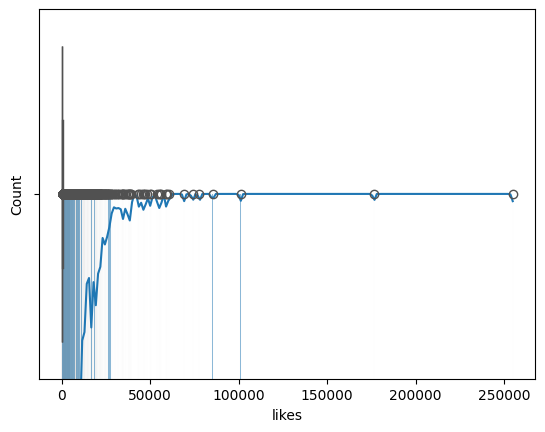

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['likes'], kde=True)
plt.title("Distribution of Tweet Likes")
plt.show()

sns.boxplot(x=df['likes'])
plt.title("Boxplot of Tweet Likes")
plt.show()


In [ ]:
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()

In [ ]:
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
df['char_count'] = df['content'].apply(len)

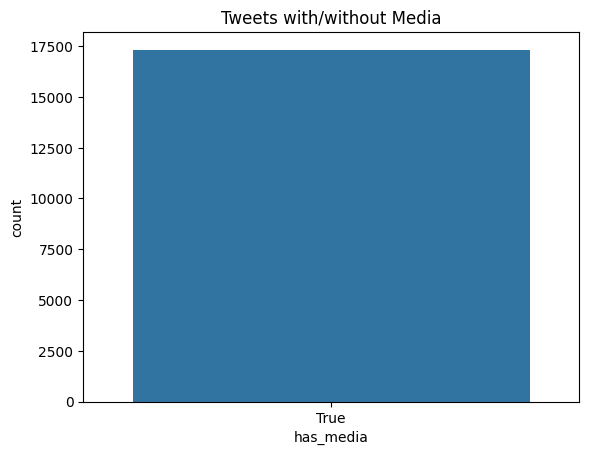

In [ ]:
sns.countplot(x=df['has_media'])
plt.title("Tweets with/without Media")
plt.show()


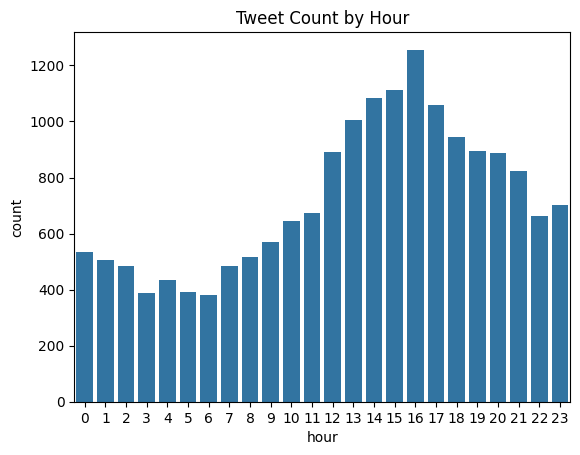

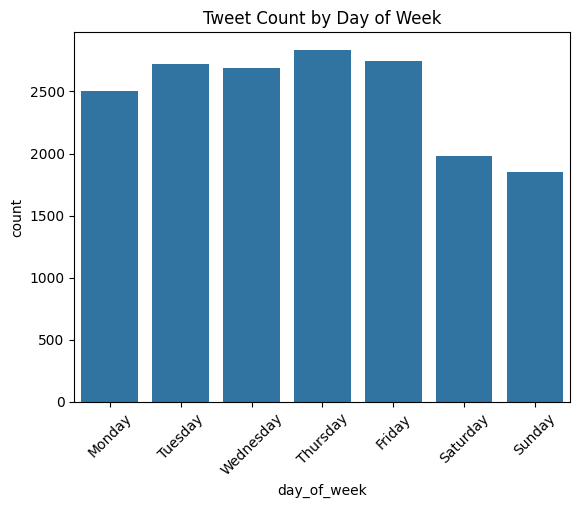

In [ ]:
sns.countplot(x=df['hour'])
plt.title("Tweet Count by Hour")
plt.show()

sns.countplot(x=df['day_of_week'], order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Tweet Count by Day of Week")
plt.xticks(rotation=45)
plt.show()


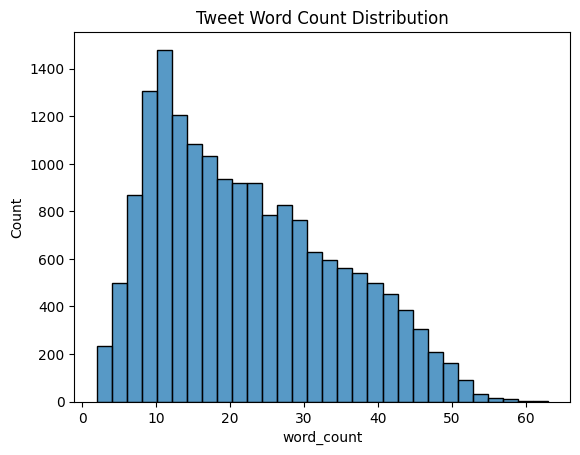

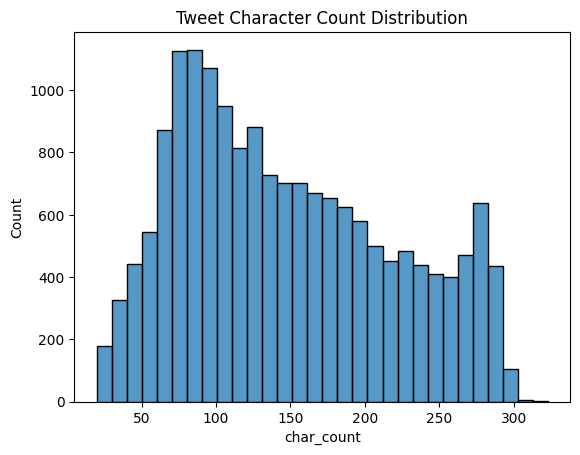

In [ ]:
sns.histplot(df['word_count'], bins=30)
plt.title("Tweet Word Count Distribution")
plt.show()

sns.histplot(df['char_count'], bins=30)
plt.title("Tweet Character Count Distribution")
plt.show()


In [ ]:
!pip install textblob --quiet

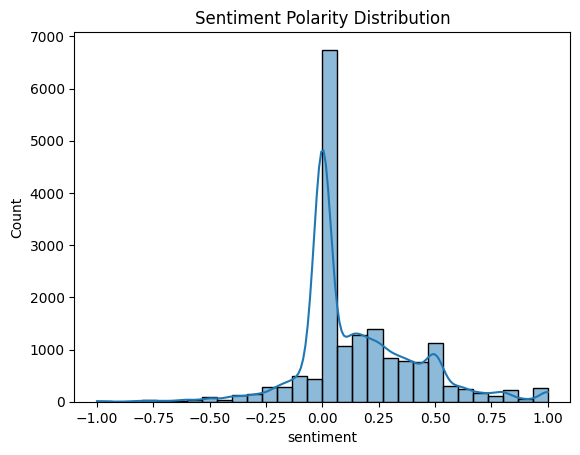

In [ ]:
from textblob import TextBlob

df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title("Sentiment Polarity Distribution")
plt.show()




```
Feature list:
company
username
content->word_count,sentiment
media->has_media
datetime->hour,day_of_week
```




In [ ]:
df['char_count'] = df['content'].apply(len)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['company_encoded'] = le.fit_transform(df['inferred company'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np

X = df[['word_count', 'char_count', 'has_media', 'hour', 'sentiment']]
y = df['likes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

joblib.dump(model, 'tweet_likes_prediction_model.pkl')
print("RMSE:", rmse)

RMSE: 3622.259291771297


In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)
model = joblib.load('tweet_likes_prediction_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = np.array([
        data['word_count'],
        data['char_count'],
        data['has_media'],
        data['hour'],
        data['sentiment']
    ]).reshape(1, -1)

    prediction = model.predict(features)[0]
    return jsonify({'predicted_likes': int(prediction)})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
